In [1]:
import seaborn as sn
import datetime

In [43]:
dat = pd.read_pickle('/RHESSys/Como/obs/como_q_obs.pcl')

In [44]:
dat.head()

,q_liter_per_day,Unnamed: 3,discharge
2004-01-01,259200.0,NaN,0.051806
2004-01-02,259200.0,NaN,0.051806
2004-01-03,259200.0,NaN,0.051806
2004-01-04,259200.0,NaN,0.051806
2004-01-05,259200.0,NaN,0.051806


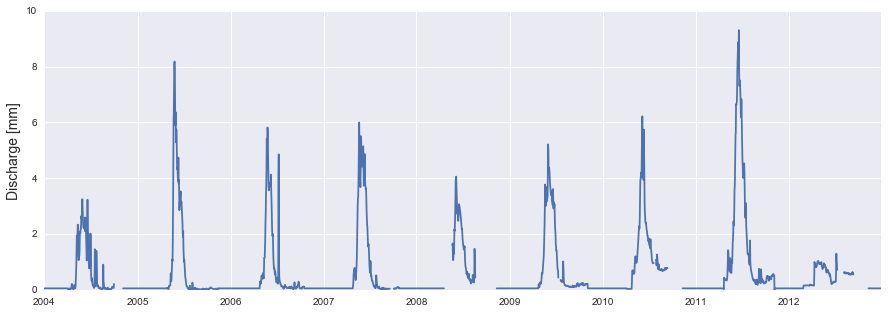

In [3]:
dat.discharge.plot(figsize=(15,5))
plt.ylabel('Discharge [mm]',fontsize = 14)

In [4]:
def DOY(date):
    year = date.year
    month = date.month
    day = date.day
    
    # compute the time since the new year with Jan 1 being DOY 1
    
    strt = datetime.datetime(year-1,12,31)
    now = datetime.datetime(year,month,day)
    
    dt = now - strt
    
    return int(dt.days)

In [5]:
def year(date):
    return int(date.year)

In [6]:
dat['dowy'] = dat.index.map(rut.DOWY)
dat['doy'] = dat.index.map(DOY)
dat['year'] = dat.index.map(year)

/Users/barnhatb/Dropbox/python/bin/rhessys/utilities.py:83: FutureWarning: pandas.core.datetools.datetime is deprecated. Please use datetime.datetime instead.
  ref = pd.datetools.datetime(int(wy)-1,10,1) # set the beginning of the water year


In [7]:
dat.head()

,q_liter_per_day,Unnamed: 3,discharge,dowy,doy,year
2004-01-01,259200.0,NaN,0.051806,93,1,2004
2004-01-02,259200.0,NaN,0.051806,94,2,2004
2004-01-03,259200.0,NaN,0.051806,95,3,2004
2004-01-04,259200.0,NaN,0.051806,96,4,2004
2004-01-05,259200.0,NaN,0.051806,97,5,2004


In [8]:
dat['wateryear'] = dat.index.map(rut.wateryear)

In [9]:
sn.set_palette('Paired',10)

In [10]:
def DOWY2cal(dowy,year,returnyear=False):
    import datetime
    strt = pd.datetime(year,9,30)
    dt = strt + datetime.timedelta(dowy)
    
    if returnyear:
        return '%s-%s-%s'%(str(int(year)),str(int(dt.month)),str(int(dt.day)))
    
    else:
        return '%s/%s'%(str(int(dt.month)),str(int(dt.day)))
    

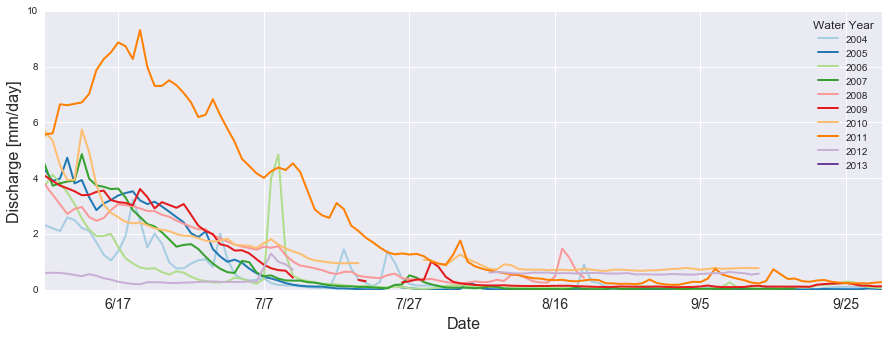

In [11]:
plt.figure(figsize=(15,5))
for wy in dat.wateryear.unique():
    df = dat.loc[dat.wateryear==wy]
    plt.plot(df.dowy,df.discharge,label = str(wy),lw=2);

plt.xlim(250,365)    
plt.legend(title='Water Year');
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Discharge [mm/day]', fontsize = 16)

ax = plt.gca()
ticks = ax.get_xticks()
labels = [DOWY2cal(dowy,2010) for dowy in ticks]
ax.set_xticklabels(labels, fontsize=14);

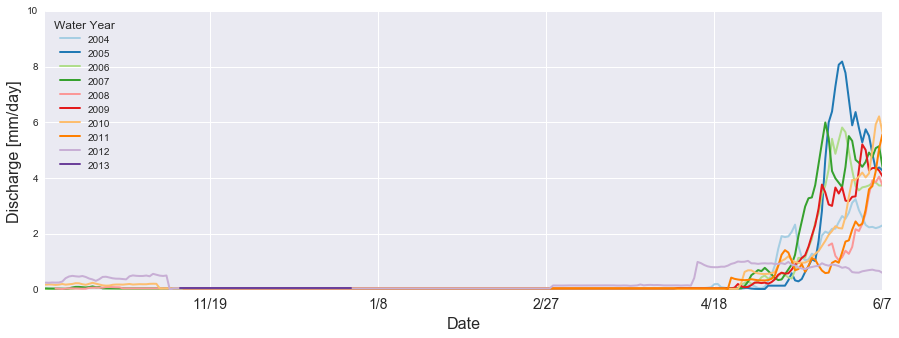

In [12]:
plt.figure(figsize=(15,5))
for wy in dat.wateryear.unique():
    df = dat.loc[dat.wateryear==wy]
    plt.plot(df.dowy,df.discharge,label = str(wy),lw=2);

plt.xlim(1,250)    
plt.legend(title='Water Year',loc='upper left');
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Discharge [mm/day]', fontsize = 16)

ax = plt.gca()
ticks = ax.get_xticks()
labels = [DOWY2cal(dowy,2010) for dowy in ticks]
ax.set_xticklabels(labels, fontsize=14);

## Sum the Volume of Snowmelt Runoff and Baseflow

In [13]:
def partition_baseflow(x,thresh=0.25):
    '''
    x - daily streamflow [length of vol]
    thresh - threshold to classify values above as runoff and below as baseflow
    '''
    if x > thresh:
        return np.NaN
    elif x <= thresh:
        return x

In [14]:
def partition_runoff(x,thresh=0.25):
    '''
    x - daily streamflow [length of vol]
    thresh - threshold to classify values above as runoff and below as baseflow
    '''
    if x >= thresh:
        return x
    elif x < thresh:
        return np.NaN

In [15]:
thresh = 0.3
dat['baseflow'] = dat.discharge.apply(partition_baseflow,thresh=thresh)
dat['runoff'] = dat.discharge.apply(partition_runoff,thresh=thresh)

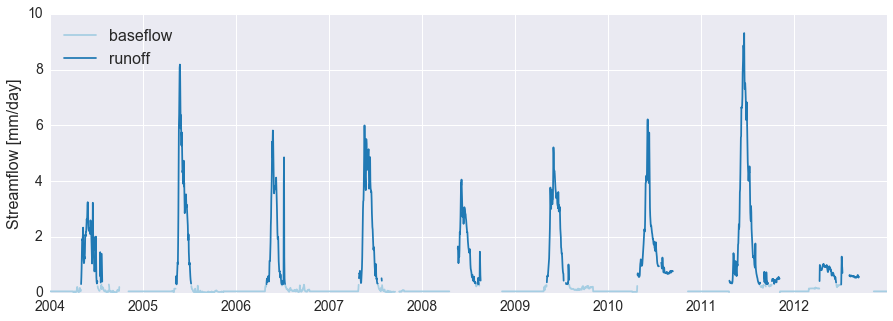

In [23]:
dat.baseflow.plot(figsize=(15,5))
dat.runoff.plot()
plt.ylabel('Streamflow [mm/day]', fontsize = 16)
plt.legend(loc='upper left', fontsize=16)
ax = plt.gca()
[tick.label.set_fontsize(14) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];
plt.savefig('./figures/como_baseflow_paritioning.png',dpi=300,bbox_inches='tight')

In [24]:
dat.groupby('wateryear').baseflow.sum()

wateryear
2004    13.063621
2005    13.804158
2006    19.972225
2007    16.341381
2008    12.589678
2009    19.388668
2010    15.565413
2011    14.133710
2012    18.843016
2013     2.693933
Name: baseflow, dtype: float64

In [25]:
dat.groupby('wateryear').runoff.sum()/dat.groupby('wateryear').discharge.sum()

wateryear
2004    0.900959
2005    0.934085
2006    0.880380
2007    0.922341
2008    0.915031
2009    0.901630
2010    0.933849
2011    0.960659
2012    0.833891
2013         NaN
dtype: float64

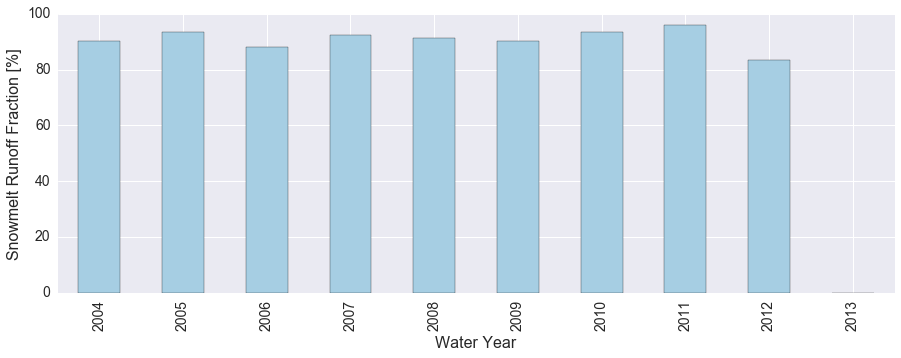

In [32]:
((dat.groupby('wateryear').runoff.sum()/dat.groupby('wateryear').discharge.sum())*100.).plot.bar(figsize=(15,5))
ax = plt.gca()
[tick.label.set_fontsize(14) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];
plt.xlabel('Water Year', fontsize=16)
plt.ylabel('Snowmelt Runoff Fraction [%]', fontsize=16)
plt.savefig('./figures/como_runoff_fraction.png',dpi=300,bbox_inches='tight')

## Identify the snowmelt period for each water year:

In [34]:
wys = [2004,2005,2006,2007,2009,2010,2011,2012]
strts = ['2004-5-1','2005-5-3','2006-4-25','2007-4-26','2009-4-23','2010-4-25',
        '2011-5-21','2012-4-10']
nds = ['2004-7-17','2005-7-17','2006-7-6','2007-7-24','2009-7-11','2010-7-17',
      '2011-8-23','2012-6-19']

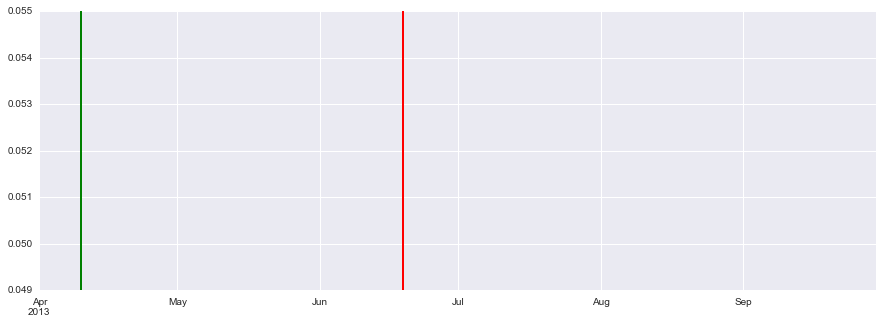

In [35]:
wy = 2013
strt = '%s-%s-%s'%(int(wy),4,10)
nd = '%s-%s-%s'%(int(wy),6,19)
dat.loc[dat.wateryear==wy].discharge.plot(figsize=(15,5))
plt.xlim('%s-%s-%s'%(wy,4,1),'%s-%s-%s'%(wy,9,30))
plt.axvline(strt,color='g',lw=2)
plt.axvline(nd,color='r',lw=2)

# Plot the whole record with start and stop dates

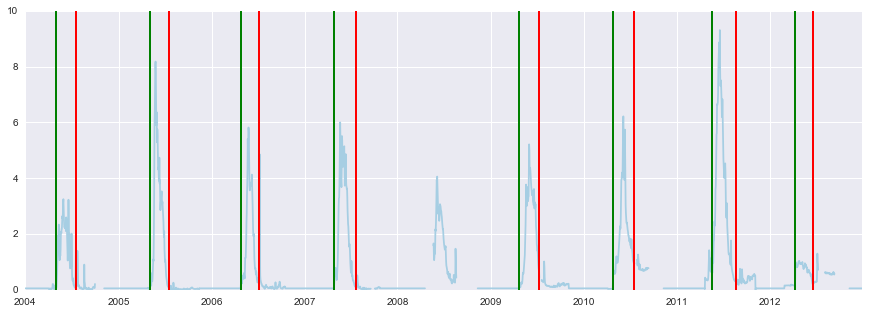

In [36]:
dat.discharge.plot(figsize=(15,5))
for wy,strt,nd in zip(wys,strts,nds):
    plt.axvline(strt,color='g',lw=2)
    plt.axvline(nd,color='r',lw=2)

In [37]:
runoff = pd.DataFrame({'strt':strts,'wy':wys,'nd':nds})

In [39]:
runoff.to_pickle('./data/como_runoff_periods.pcl')

In [42]:
runoff.loc[runoff.wy==2004,'strt'][0]

'2004-5-1'

In [ ]:
dat.dropna()